In [1]:
import time
import math
import copy
import torch
import pickle
import random
import logging
import warnings
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as opt
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
import fairlearn.datasets
from tqdm import tqdm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from torch.autograd import grad
from torch.autograd.functional import vhp
from get_datasets import get_law
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score
from scipy.stats import spearmanr

plt.rcParams['figure.dpi'] = 300
warnings.filterwarnings("ignore")

E = math.e

### Utility Functions

In [2]:
def visualize_result(e_k_actual, e_k_estimated, ep, k_):

    e_k_estimated = [-1*ek for ek in e_k_estimated]
    fig, ax = plt.subplots()
    palette = sns.color_palette("cool", len(e_k_actual))
    sns.set(font_scale=1.15)
    sns.set_style(style='white')
    min_x = np.min(e_k_actual)
    max_x = np.max(e_k_actual)
    min_y = np.min(e_k_estimated)
    max_y = np.max(e_k_estimated)
    
    plt.rcParams['figure.figsize'] = 6, 5
    z = np.polyfit(e_k_actual,  e_k_estimated, 1)
    p = np.poly1d(z)
    xx = np.linspace(-p(2)/p(1), max(e_k_actual)+.0001)
    yy = np.polyval(p, xx)
    #add trendline to plot
    ax.plot(xx, yy, ls="-", color='k')
    for k in range(len(e_k_actual)):
        ax.scatter(e_k_actual[k], e_k_estimated[k], zorder=2, s=45, color = palette[k], label=ep[k])

    ax.set_title(f'Actual vs. Estimated loss for k={k_:.2f}%')
    ax.set_xlabel('Actual loss difference')
    ax.set_ylabel('Estimated loss difference')
   
    ax.set_xlim(min_x-.0001, max_x+.0001)
    ax.set_ylim(min_y-.0001, max_y+.0001)
    
   
    text = 'MAE = {:.03}\nP = {:.03}'.format(mean_absolute_error(e_k_actual, e_k_estimated), spearmanr(e_k_actual, e_k_estimated).correlation)
    ax.text(max_x+.00009,min_y-.00008, text, verticalalignment='bottom', horizontalalignment='right')
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.tight_layout()
    plt.xticks(rotation = 45)
    plt.show()
    # cooler color = smaller epsilon

In [3]:
 class CreateData(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.targets[idx]

        return out_data, out_label

In [4]:
def get_data(new_train_df, feature_set, label, k):    

    selected_group = new_train_df.loc[new_train_df['Gender'] == 0]

    num_to_sample = round((k / 100)*len(selected_group))

    sampled_group = selected_group.sample(n=num_to_sample)
    not_selected = new_train_df.drop(sampled_group.index)

    selected_group_X = sampled_group[feature_set]
    selected_group_y = sampled_group[label]

    not_selected_group_X = not_selected[feature_set]
    not_selected_group_y = not_selected[label]   
    
    return selected_group_X, selected_group_y, not_selected_group_X, not_selected_group_y

### Randomized Response

In [5]:
def get_p(epsilon):
    probability = float(E ** epsilon) / float(1 + (E ** epsilon))
    p = torch.FloatTensor([[probability, 1-probability], [1-probability, probability]])
    
    return p

### Models

In [6]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, num_features):
        super(LogisticRegression, self).__init__()
        
        self.fc1 = torch.nn.Linear(num_features, 1, bias=False)
        self.criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
        
    def forward(self, x):
        logits = self.fc1(x)

        return logits
    
    def loss(self, logits, y, print_):
        loss = self.criterion(logits.ravel(), y)
        
        probabilities = torch.sigmoid(logits)
        thresh_results = []
        
        for p in probabilities:
            if p>.5:
                thresh_results.append(1)
            else:
                thresh_results.append(0)
                
        num_correct = 0
        for r,y_ in zip(thresh_results, y):
            if r == y_:
                num_correct += 1
                
        acc = num_correct / len(y)
        
        if print_:
            print("Accuracy is {0:.3f}".format(acc*100))
            print("Precision is {0:.3f}".format(precision_score(y.detach().cpu().numpy(), thresh_results, zero_division=0)))
            print("Recall is {0:.3f}".format(recall_score(y.detach().cpu().numpy(), thresh_results)))
        return loss, acc

In [7]:
def train(model, dataset):
    model.train()
    
    opt = torch.optim.SGD(model.parameters(), lr=.5, weight_decay=0)
   
    criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
            
    train_data = CreateData(dataset[0], dataset[1])
    train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)

    for itr in range(0, 20):
        itr_loss = 0
        for i, [x,y] in enumerate(train_dataloader):
            opt.zero_grad()
            oupt = model(x)
            
            try:
                loss_val = criterion(oupt.ravel(), y)
            except ValueError:
                loss_val = criterion(oupt, y)
            itr_loss += loss_val
            loss_val.backward()
            opt.step() 
       
    return model

### Influence Calculation Functions


In [8]:
def calc_influence_single(model, epsilon, train_data, test_data, group_data, device, num_features, criterion):
    start = time.time()
    est_hess = explicit_hess(model, train_data, device, criterion)

    grad_test = grad_z([test_data[0], test_data[1]], model, device, criterion)
    s_test_vec = torch.mm(grad_test[0], est_hess.to(device))

    P = get_p(epsilon)
    
    p_01, p_10 = P[0][1].item(), P[1][0].item()
    
    pi_1 = sum(list(group_data[1]))
    pi_0 = len(group_data[1]) - pi_1
    
    lam_0 = round(p_01 * pi_1)
    lam_1 = round(p_10 * pi_0)

    S_pert = 1 - group_data[1]
    
    y_w_group_pert = pd.concat([group_data[3], S_pert], axis = 0, ignore_index=True)
    y_wo_pert = pd.concat([group_data[3], group_data[1]], axis = 0, ignore_index=True)
    reconstructed_x = pd.concat([group_data[2], group_data[0]], axis = 0, ignore_index=True)
  
    assert len(S_pert) == len(group_data[1])
    grad_z_vec = grad_training([group_data[0],group_data[1]], S_pert, [model], device, [lam_0, lam_1, epsilon], criterion)
    
    influence = torch.dot(s_test_vec.flatten(), grad_z_vec[0].flatten()) * (1/len(train_data[0]))
    end = time.time() - start

    return influence.cpu(), end

In [9]:
def explicit_hess(model, train_data, device, criterion):
 
    logits = model(train_data[0])
    loss = criterion(logits.ravel(), train_data[1]) #reduction mean
    
    grads = grad(loss, model.parameters(), retain_graph=True, create_graph=True)

    hess_params = torch.zeros(len(model.fc1.weight[0]), len(model.fc1.weight[0]))
    
    for i in range(len(model.fc1.weight[0])):
        hess_params_ = grad(grads[0][0][i], model.parameters(), retain_graph=True)[0][0]
        for j, hp in enumerate(hess_params_):
            hess_params[i,j] = hp

            
    inv_hess = torch.linalg.inv(hess_params)
    return inv_hess

In [10]:
def grad_z(test_data, model, device, criterion):

    model.eval()

    test_data_features = test_data[0]
    test_data_labels = test_data[1]

    logits = model(test_data_features)
    loss = criterion(logits, torch.atleast_2d(test_data_labels).T) # reduction mean
    
    return grad(loss, model.parameters())

In [11]:
def grad_training(train_data, y_perts, parameters, device, epsilon, criterion):
    
    criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
    
    lam_0, lam_1, ep = epsilon
    lam = lam_0 + lam_1
    len_s = len(y_perts)
    
    train_data_features = torch.FloatTensor(train_data[0].values).to(device)
    train_data_labels = torch.FloatTensor(train_data[1].values).to(device)
    train_pert_data_labels = torch.FloatTensor(y_perts.values).to(device)
    
    model = parameters[0]
    model.eval()

    logits = model(train_data_features)

    orig_loss = criterion(logits, torch.atleast_2d(train_data_labels).T)
    pert_loss = criterion(logits, torch.atleast_2d(train_pert_data_labels).T)
    loss = float(1/(1 + (E ** ep)))*(pert_loss - orig_loss)
    
    to_return = grad(loss, model.parameters())
    
        
    return to_return

### Main Function

In [12]:
def Main(dataset, epsilons, ks, num_rounds):

    device = 'cuda:6' if torch.cuda.is_available() else 'cpu'
    criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
    
    all_orig_loss_e_k = []
    all_est_loss_e_k = []
    all_time = []
    
    for nr in range(num_rounds):
        print(f'\nRound {nr+1}')
        ############
        # Get data #
        ############
        print('\nGetting Data...')
        if dataset == 'adult':
            data = get_adult()
            label = 'income_class'
        elif dataset == 'diabetes':
            data = get_diabetes()
            label = 'readmit_binary'
        else:
            data = get_law()
            label = 'admit'

        feature_set = set(data.columns) - {label}
        num_features = len(feature_set)
    
        X = data[feature_set]
        y = data[label]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
       
        new_train_df = pd.concat([X_train, y_train], axis=1)
  
        train_sample_num = len(X_train)
    
        x_test_input = torch.FloatTensor(X_test.values).to(device)
        y_test_input = torch.FloatTensor(y_test.values).to(device)

        x_train_input = torch.FloatTensor(X_train.values).to(device)
        y_train_input = torch.FloatTensor(y_train.values).to(device)
   
        ##############################################
        # Train original model and get original loss #
        ##############################################
        print('Training original model...')
        torch_model = LogisticRegression(num_features)
        torch.save(torch_model.state_dict(), 'initial_config.pth')
        torch_model.to(device)
        torch_model = train(torch_model, [x_train_input, y_train_input])
        test_loss_ori, acc_ori = torch_model.loss(torch_model(x_test_input), y_test_input, True)

        e_k_act_losses = []
        e_k_est_losses = []
        influence_time = []
        
        ################################################################
        # Perform influence and retraining for all epsilons a k values #
        ################################################################
        print('\nBegining epsilon and k rounds')
        print('-----------------------------')
        for ep in epsilons:
            print(f'\nEpsilon: {ep}')
            
            k_act_losses = []
            k_est_losses = []
            inf_time = []
            
            for k in ks:
                # Influence
                print(f'k: {k:.2f}')
                selected_group_X, selected_group_y, not_selected_group_X, not_selected_group_y = get_data(new_train_df, feature_set, label, k)
                loss_diff_approx, tot_time = calc_influence_single(torch_model, ep, [x_train_input, y_train_input], [x_test_input, y_test_input], [selected_group_X, selected_group_y, not_selected_group_X, not_selected_group_y], device, num_features, criterion)
                loss_diff_approx = -torch.FloatTensor(loss_diff_approx).cpu().numpy()
                print(f'Approx difference: {loss_diff_approx:.5f}')
                # Retrain
                P = get_p(ep)

                p_01, p_10 = P[0][1].item(), P[1][0].item()

                pi_1 = sum(list(selected_group_y))
                pi_0 = len(selected_group_y) - pi_1

                lam_0 = round(p_01 * pi_1)
                lam_1 = round(p_10 * pi_0)

                S = pd.concat([selected_group_X, selected_group_y], axis=1, ignore_index=False)

                G0 = S[label][S[label].eq(1)].sample(lam_0).index
                G1 = S[label][S[label].eq(0)].sample(lam_1).index

                G = S.loc[G0.union(G1)]
                not_g = S.drop(G0.union(G1))

                G_pert = 1 - G[label]

                y_w_group_pert = pd.concat([not_selected_group_y, not_g[label], G_pert], axis = 0, ignore_index=True)
                y_wo_pert = pd.concat([not_selected_group_y, not_g[label], G[label]], axis = 0, ignore_index=True)
                reconstructed_x = pd.concat([not_selected_group_X, not_g[feature_set], G[feature_set]], axis = 0, ignore_index=True)

                model_pert = LogisticRegression(num_features)
                model_pert.load_state_dict(torch.load('initial_config.pth'))
                model_pert.to(device)
                model_pert = train(model_pert, [torch.FloatTensor(reconstructed_x.values).to(device), torch.FloatTensor(y_w_group_pert.values).to(device)])
                test_loss_retrain, acc_retrain = model_pert.loss(model_pert(x_test_input), y_test_input, False)

                 # get true loss diff
                loss_diff_true = (test_loss_retrain - test_loss_ori).detach().cpu().item()
                print(f'True difference: {loss_diff_true:.5f}')
                k_act_losses.append(loss_diff_true)
                k_est_losses.append(loss_diff_approx)
                inf_time.append(tot_time)
            
            e_k_act_losses.append(k_act_losses)
            e_k_est_losses.append(k_est_losses)
            influence_time.append(inf_time)
            
        all_orig_loss_e_k.append(e_k_act_losses)
        all_est_loss_e_k.append(e_k_est_losses) 
        all_time.append(influence_time)
    
    return all_orig_loss_e_k, all_est_loss_e_k, all_time

### Perform Experiment 

#### Constants

In [13]:
epsilons = [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
k = np.linspace(1, 25, 10) # 25 - adult, 30 - diabetes
rounds = 3

In [ ]:
all_orig_loss_e_k, all_est_loss_e_k, all_time = Main('law', epsilons, k, rounds)
# [round1[epsilon1[k1,...k10], epsilon2[k1,...k10],...], round2[...]]     

with open('all_orig_loss_e_k_law.txt', "wb") as file:   #Pickling
    pickle.dump(all_orig_loss_e_k, file)

with open('all_est_loss_e_k_law.txt', "wb") as file2:   #Pickling
    pickle.dump(all_est_loss_e_k, file2)


Round 1

Getting Data...
Training original model...
Accuracy is 71.380
Precision is 0.710
Recall is 0.823

Begining epsilon and k rounds
-----------------------------

Epsilon: 0.01
k: 1.00
Approx difference: -0.00033
True difference: 0.00140
k: 3.67
Approx difference: -0.00081
True difference: 0.01996
k: 6.33
Approx difference: -0.00127
True difference: -0.00013
k: 9.00
Approx difference: -0.00203
True difference: 0.00743
k: 11.67
Approx difference: -0.00228
True difference: 0.00468
k: 14.33
Approx difference: -0.00318
True difference: 0.01014
k: 17.00
Approx difference: -0.00397
True difference: 0.00461
k: 19.67
Approx difference: -0.00549
True difference: 0.00327
k: 22.33
Approx difference: -0.00504
True difference: 0.00673
k: 25.00
Approx difference: -0.00609
True difference: 0.00061

Epsilon: 0.02
k: 1.00
Approx difference: -0.00024
True difference: 0.00969
k: 3.67
Approx difference: -0.00081
True difference: -0.00133
k: 6.33
Approx difference: -0.00167
True difference: -0.00010


True difference: 0.00137
k: 22.33
Approx difference: -0.00393
True difference: 0.00157
k: 25.00
Approx difference: -0.00482
True difference: 0.00448

Epsilon: 0.5
k: 1.00
Approx difference: -0.00008
True difference: 0.00591
k: 3.67
Approx difference: -0.00052
True difference: 0.00138
k: 6.33
Approx difference: -0.00134
True difference: 0.00292
k: 9.00
Approx difference: -0.00187
True difference: -0.00088
k: 11.67
Approx difference: -0.00184
True difference: 0.00859
k: 14.33
Approx difference: -0.00246
True difference: 0.00463
k: 17.00
Approx difference: -0.00283
True difference: 0.00807
k: 19.67
Approx difference: -0.00356
True difference: 0.01374
k: 22.33
Approx difference: -0.00365
True difference: 0.00241
k: 25.00
Approx difference: -0.00440
True difference: 0.00221

Epsilon: 0.6
k: 1.00
Approx difference: -0.00016
True difference: -0.00075
k: 3.67
Approx difference: -0.00069
True difference: 0.02846
k: 6.33
Approx difference: -0.00141
True difference: -0.00152
k: 9.00
Approx differ

In [ ]:
with open('all_orig_loss_e_k_law.txt', 'rb') as f:
    all_orig_loss_e_k = pickle.load(f)
    
with open('all_est_loss_e_k_law.txt', 'rb') as f:
    all_est_loss_e_k = pickle.load(f)

In [19]:
# [actual, estimate]

sum_orig_loss_e_k = [[0 for _ in range(len(k))] for _ in range(len(epsilons))]
sum_est_loss_e_k = [[0 for _ in range(len(k))] for _ in range(len(epsilons))]
sum_time = [[0 for _ in range(len(k))] for _ in range(len(epsilons))]

avg_orig_loss = []
avg_est_loss = []
avg_time = []

for round_ in range(len(all_orig_loss_e_k)):
    for e in range(len(epsilons)):
        for k_ in range(len(k)):
            sum_orig_loss_e_k[e][k_] = sum_orig_loss_e_k[e][k_] + all_orig_loss_e_k[round_][e][k_]
            sum_est_loss_e_k[e][k_] = sum_est_loss_e_k[e][k_] + all_est_loss_e_k[round_][e][k_]
            sum_time[e][k_] = sum_time[e][k_] + all_time[round_][e][k_]

for e in range(len(epsilons)):
    avg_orig_loss.append([ elem / len(all_orig_loss_e_k) for elem in sum_orig_loss_e_k[e]])
    avg_est_loss.append([elem/ len(all_orig_loss_e_k) for elem in sum_est_loss_e_k[e]])
    avg_time.append([elem/ len(all_orig_loss_e_k) for elem in sum_time[e]])

k_e_orig = [[] for _ in range(len(k))]
k_e_est = [[] for _ in range(len(k))]

for e in range(len(epsilons)):
    for k_ in range(len(k)):
        k_e_orig[k_].append(avg_orig_loss[e][k_])
        k_e_est[k_].append(avg_est_loss[e][k_])
        
print(k_e_est)

averaged_time = []

for e in range(len(epsilons)):
    averaged_time.append(sum_time[e][0])

average_time_final = sum(averaged_time) / len(averaged_time)

[[-0.0001888995927098828, -5.381555820349604e-05, -2.8908572858199477e-05, -0.00014548933055872718, -0.00029761146773428965, -0.0002018237622299542, -0.0002802082478107574, -0.00015412782280084988, -0.00016716050352746, -0.00011074230133090168, -0.00018136178308244175, -0.0001508082762787429, -0.0002114347783693423, -0.00017533408754388802, -0.00027891537562633556, -0.00011432423790817363, -0.00011139425381164376, -8.092762315451789e-05, -0.0001898384113398303, -8.915477337723132e-05, -1.915163011290133e-06, -1.3897208305024833e-05, 1.2673203286794887e-06, -1.3742091861483157e-06, -1.890324436241523e-07, -1.0049434706616012e-07, -7.1873286581573365e-09, -7.552458806496057e-09], [-0.0002122259271952013, -0.0010502914859292407, -0.0003988995837668578, -0.0005701948199809218, -0.00031378457788378, -0.0007101562320409963, -0.00097136430364723, -0.000573694909689948, -0.0005195508808052788, -0.0006886421421465153, -0.00021928961602194855, -0.0005708003688293198, -0.0009244806654654288, -0.0

In [20]:
k = np.linspace(1, 25, 10)
k_ = list(k)
k_

[1.0,
 3.6666666666666665,
 6.333333333333333,
 9.0,
 11.666666666666666,
 14.333333333333332,
 17.0,
 19.666666666666664,
 22.333333333333332,
 25.0]

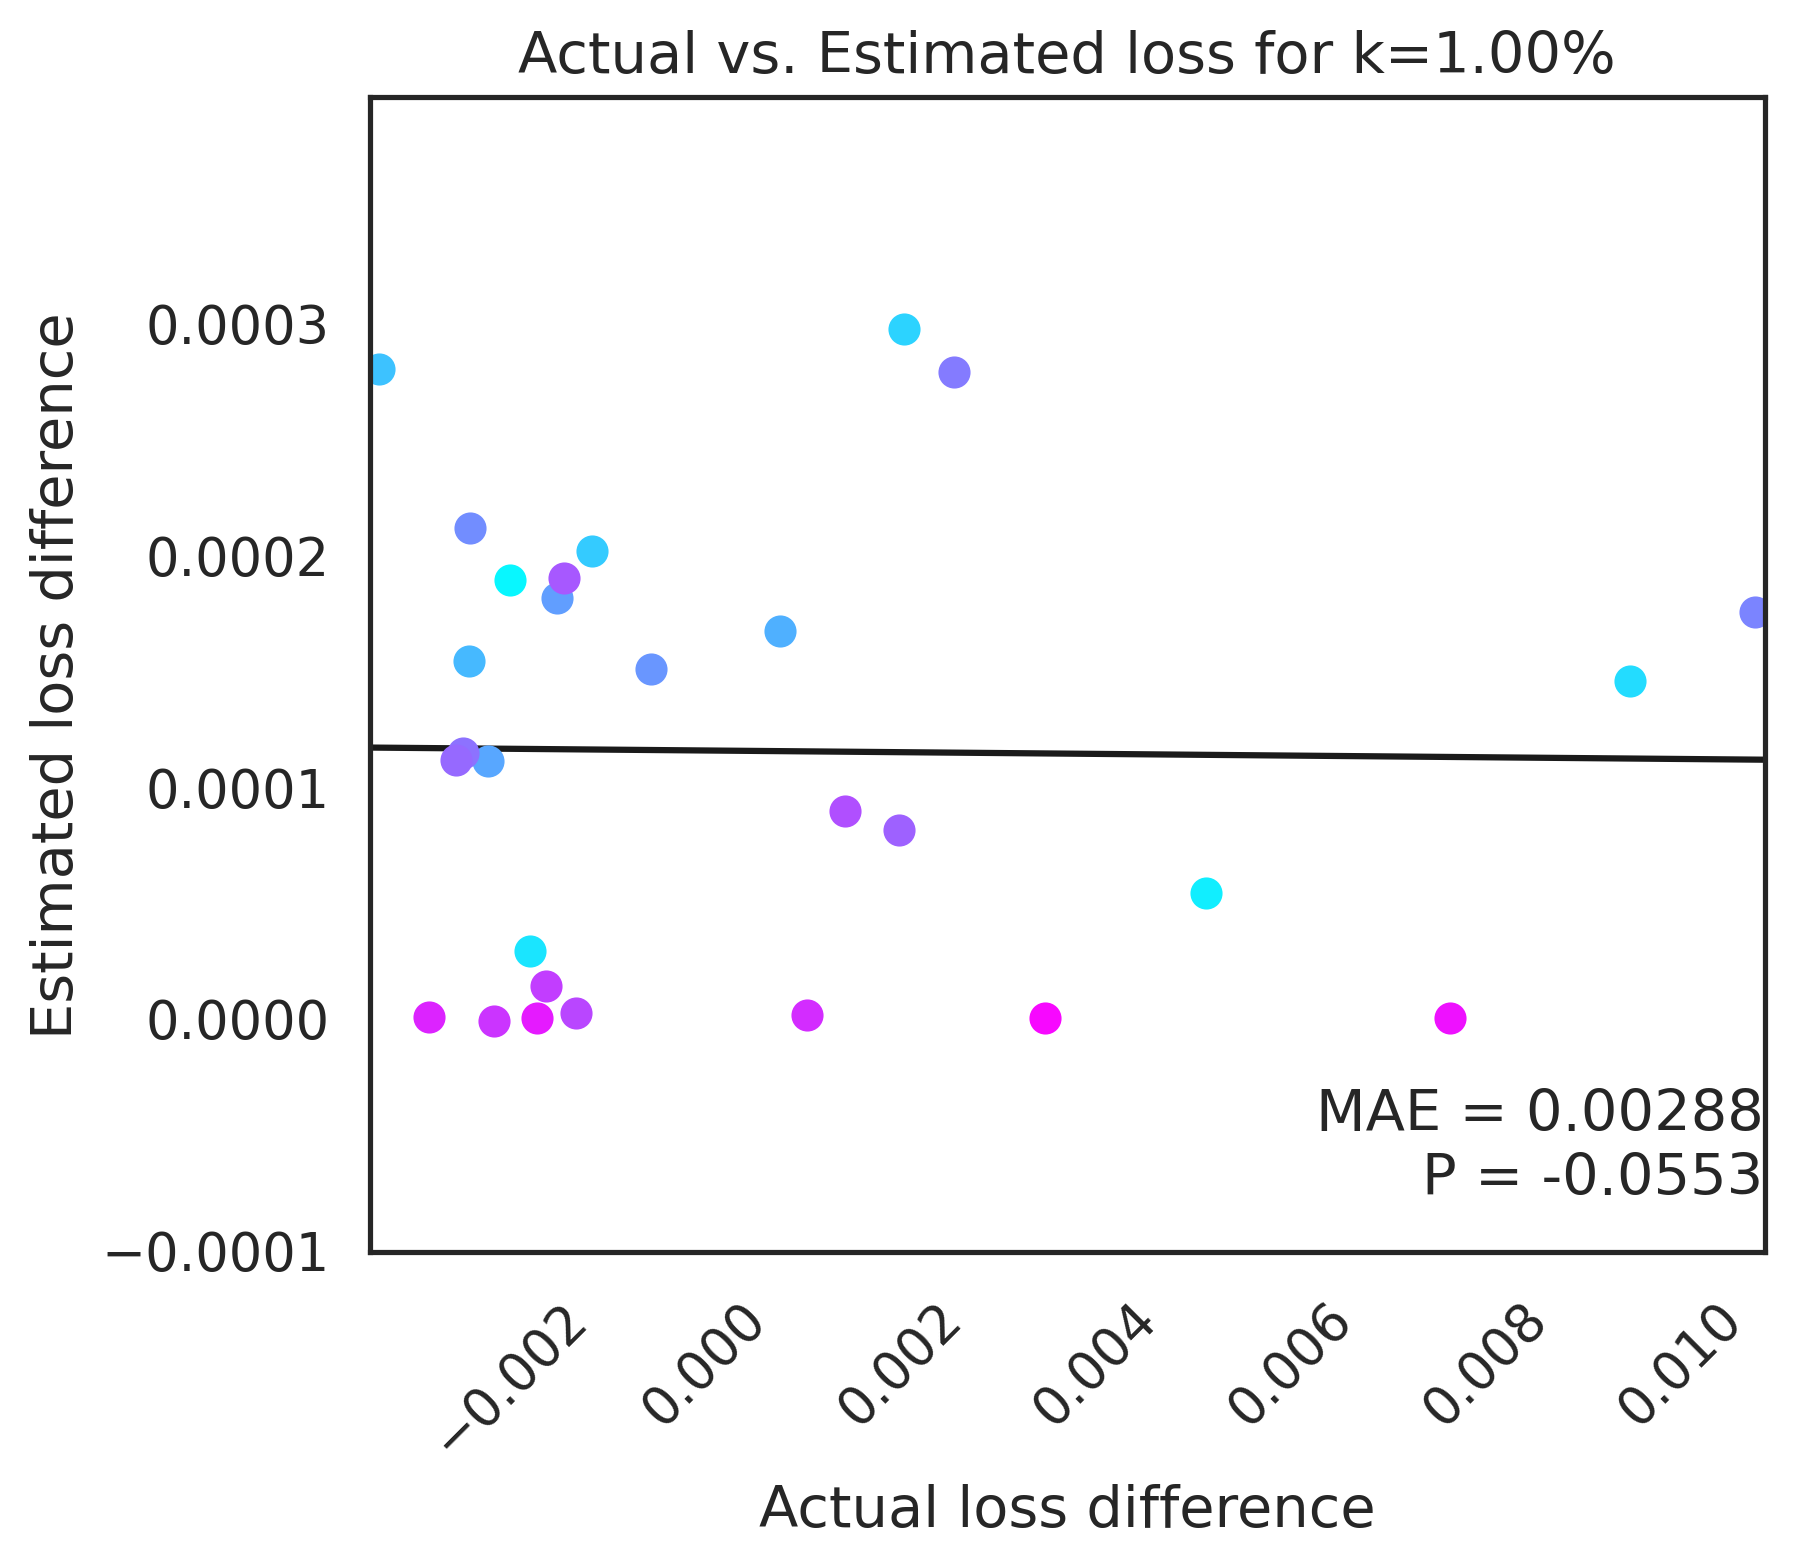

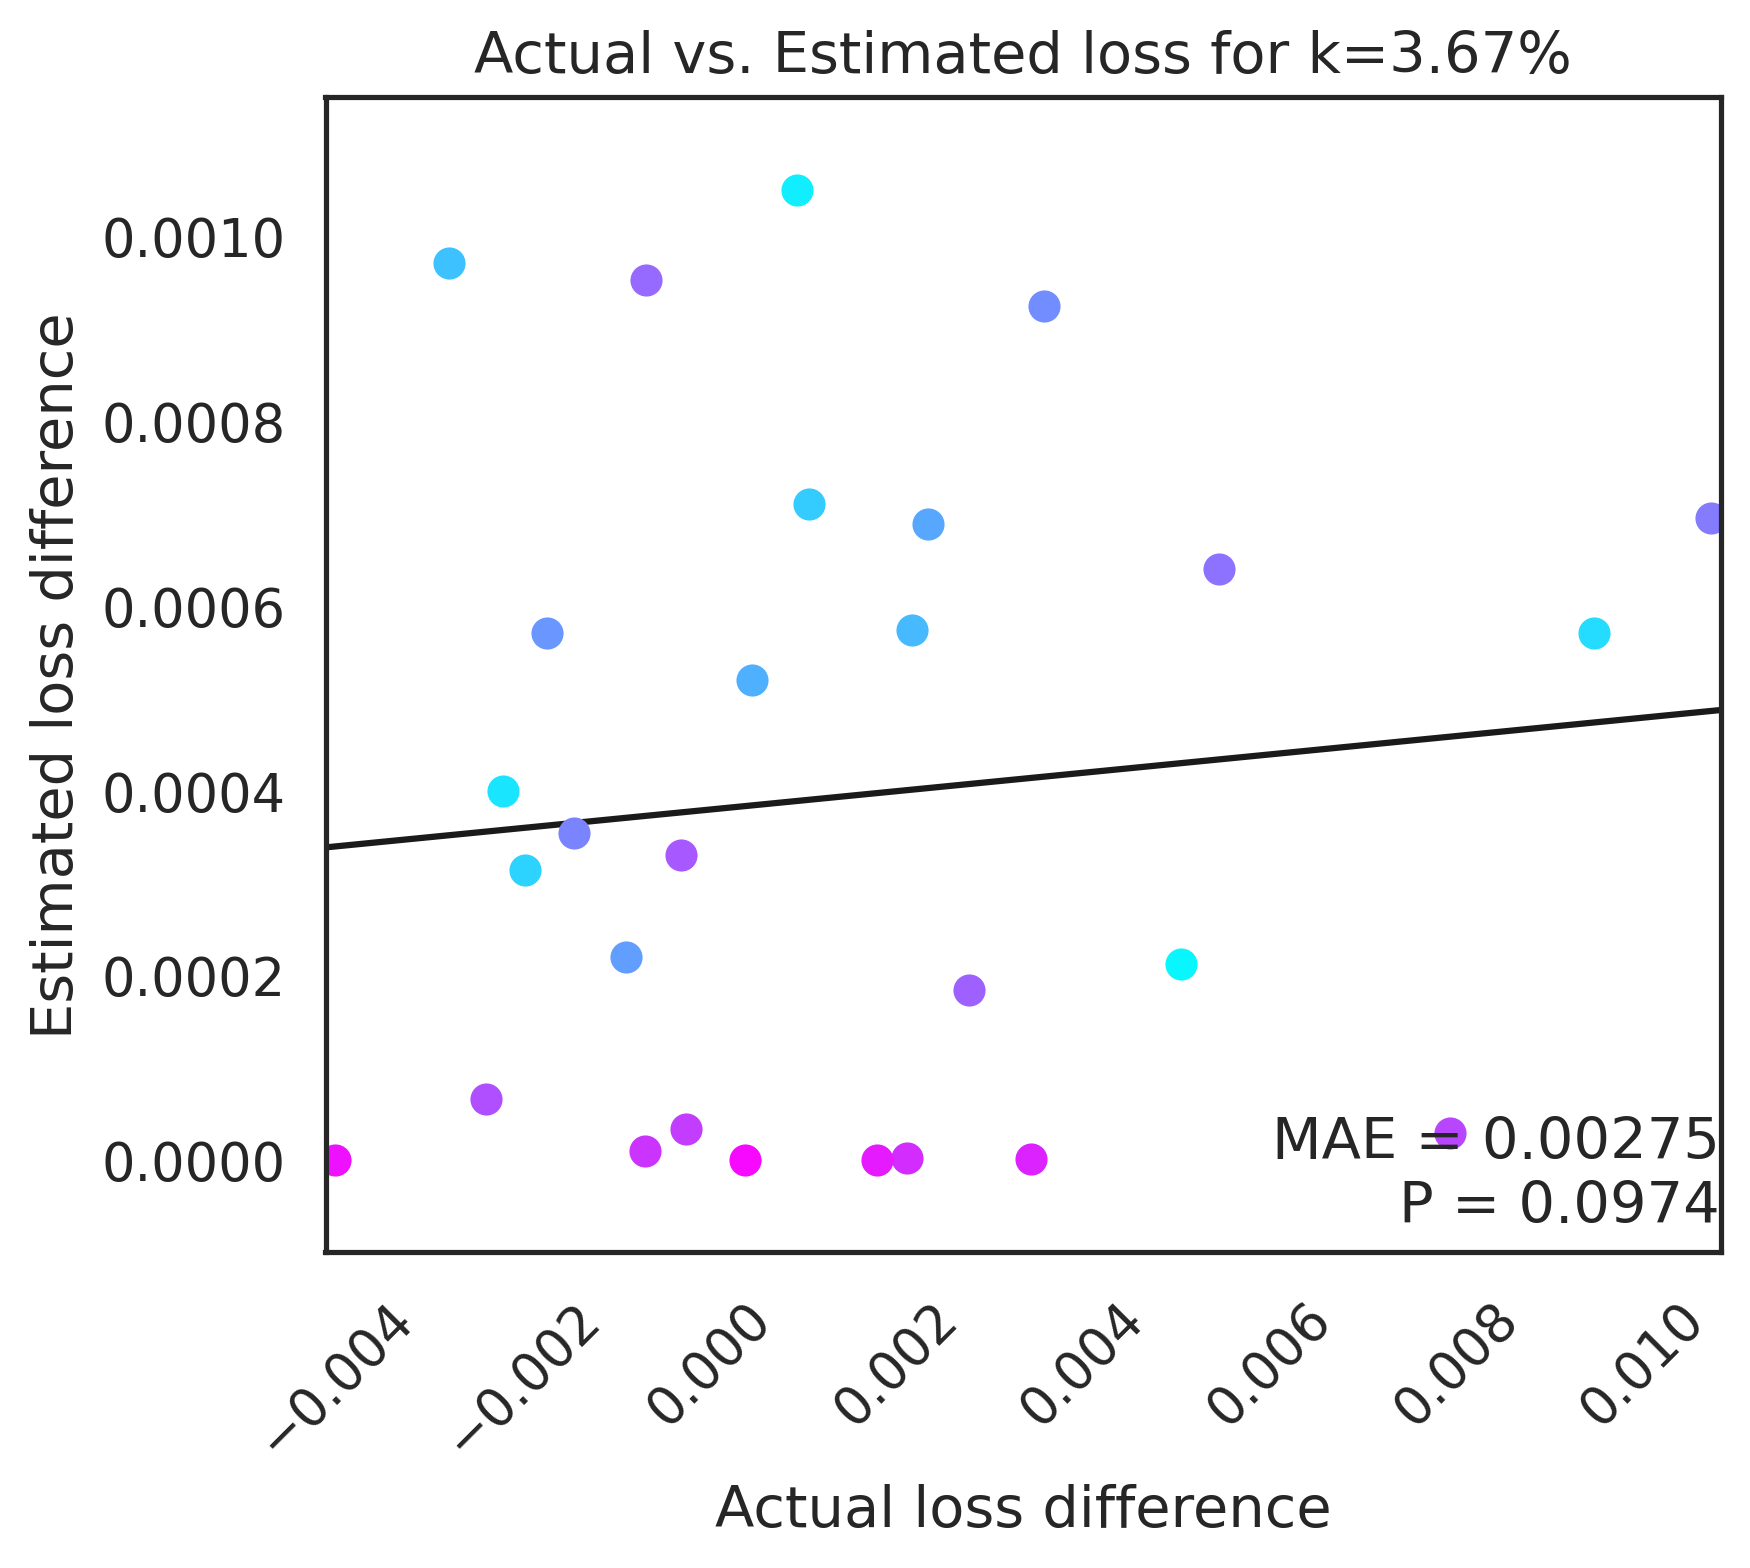

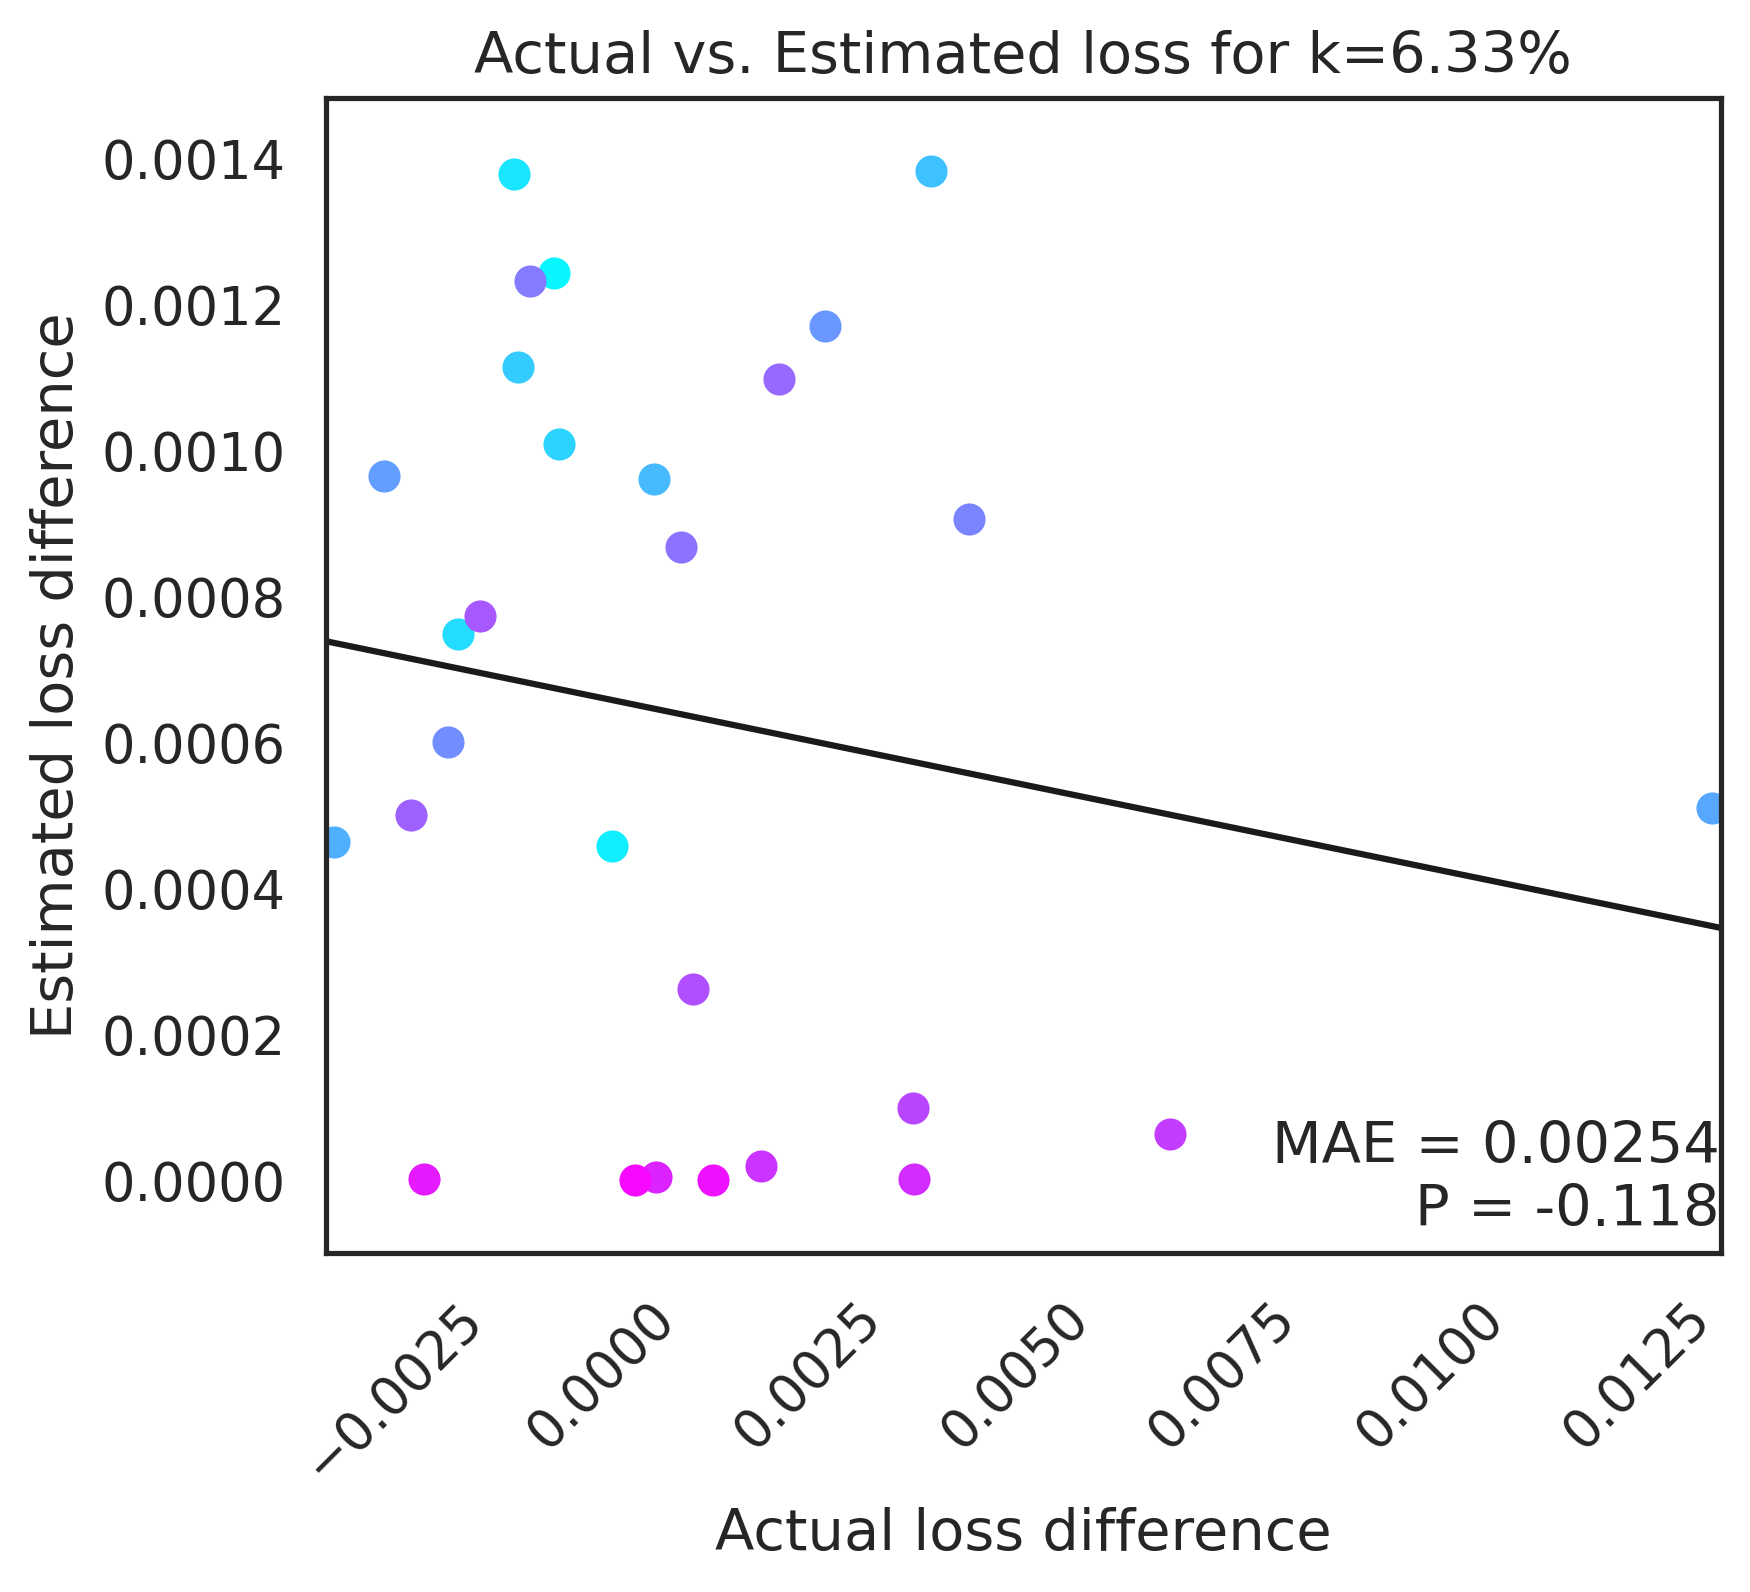

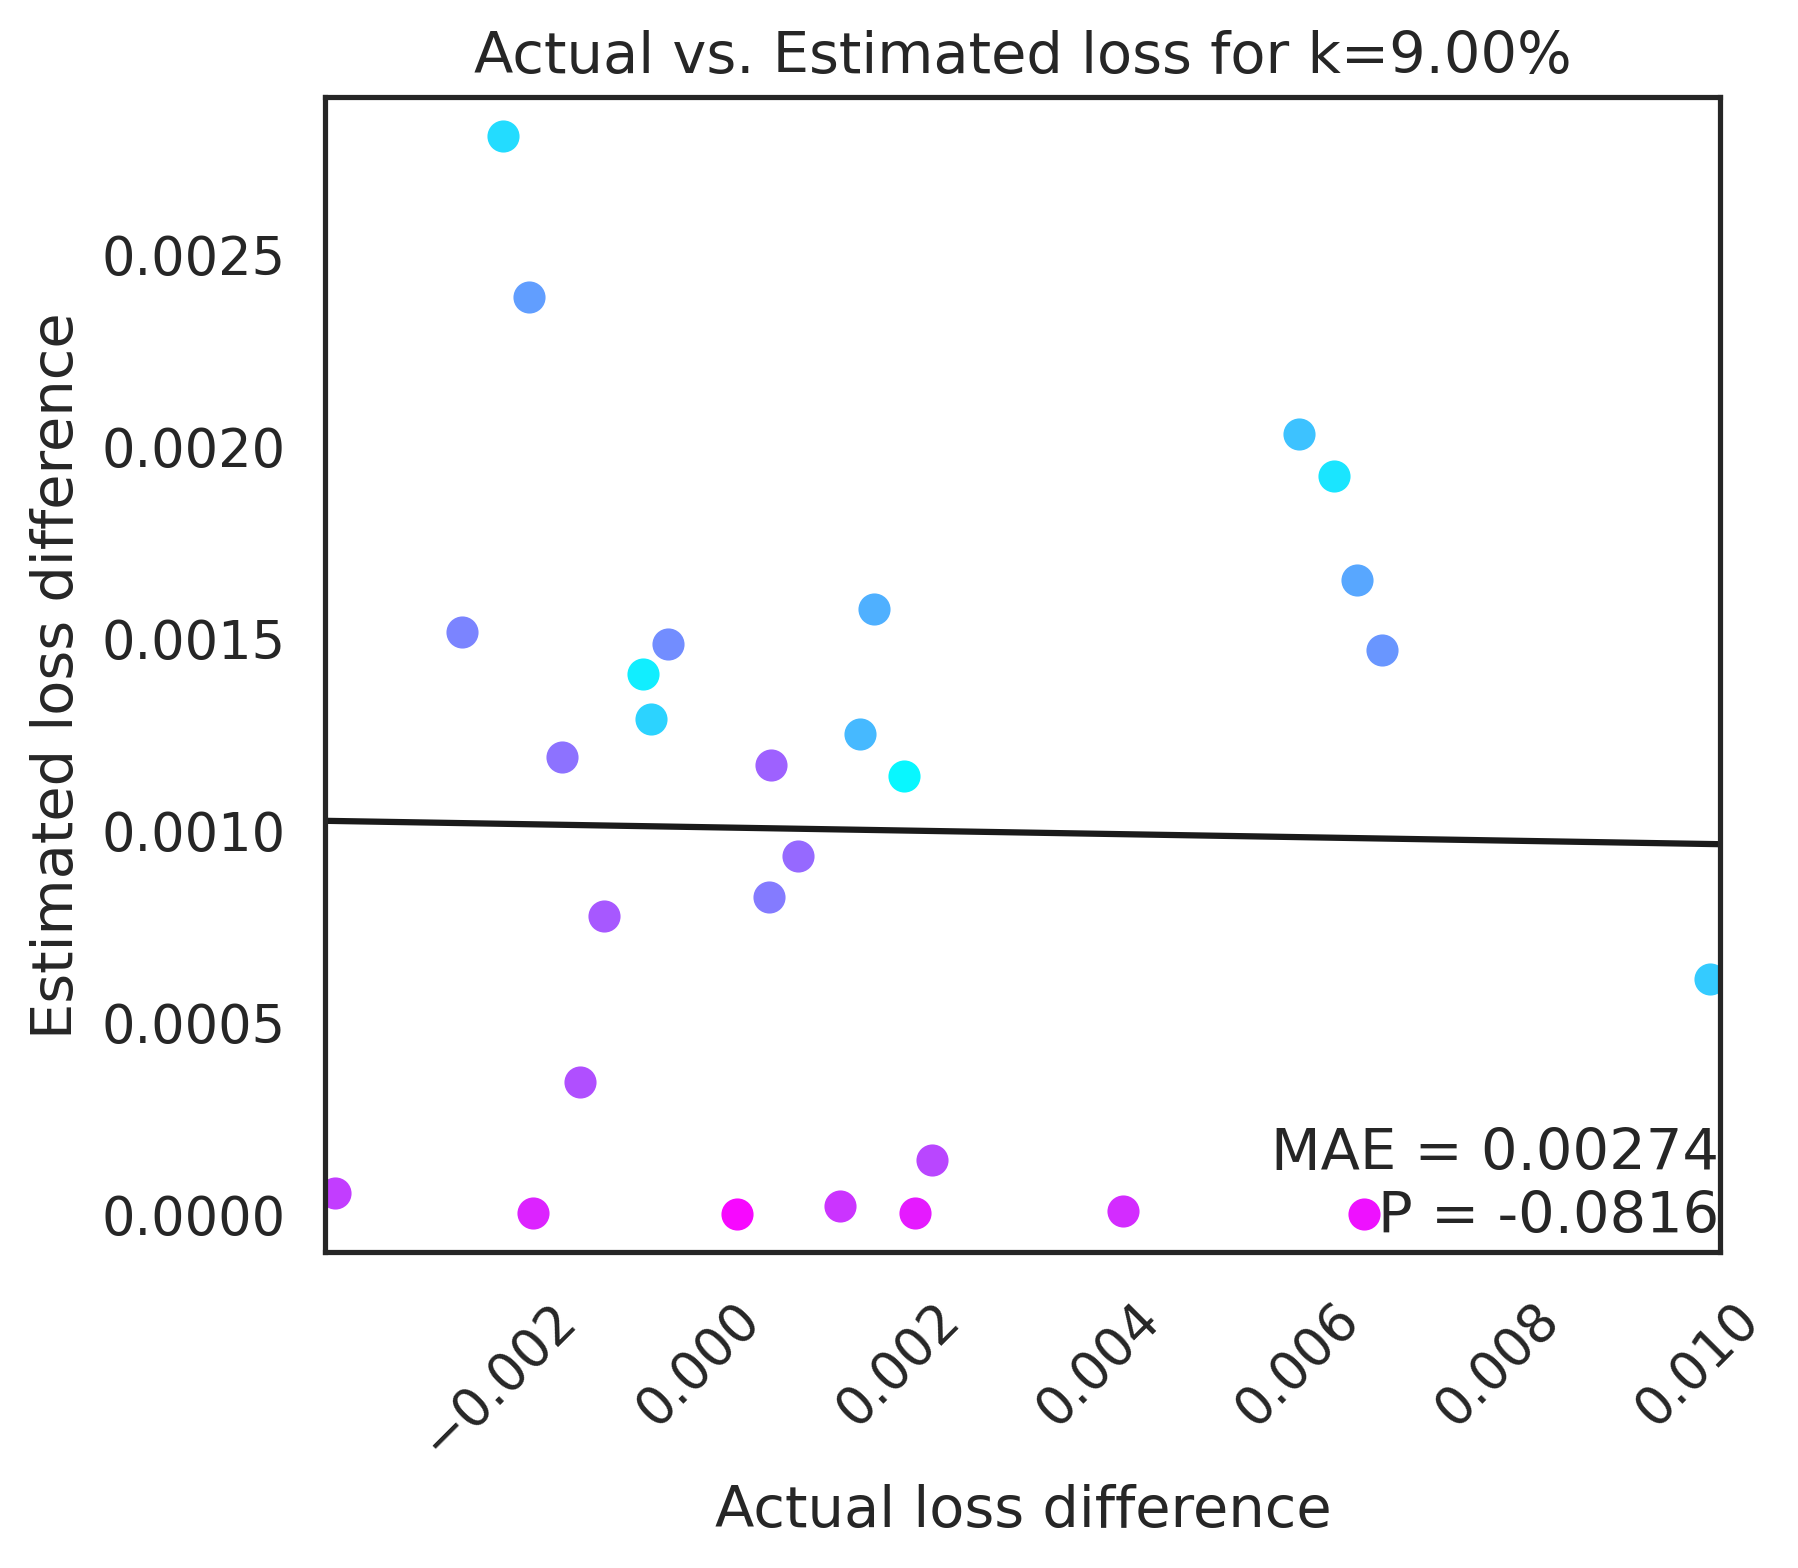

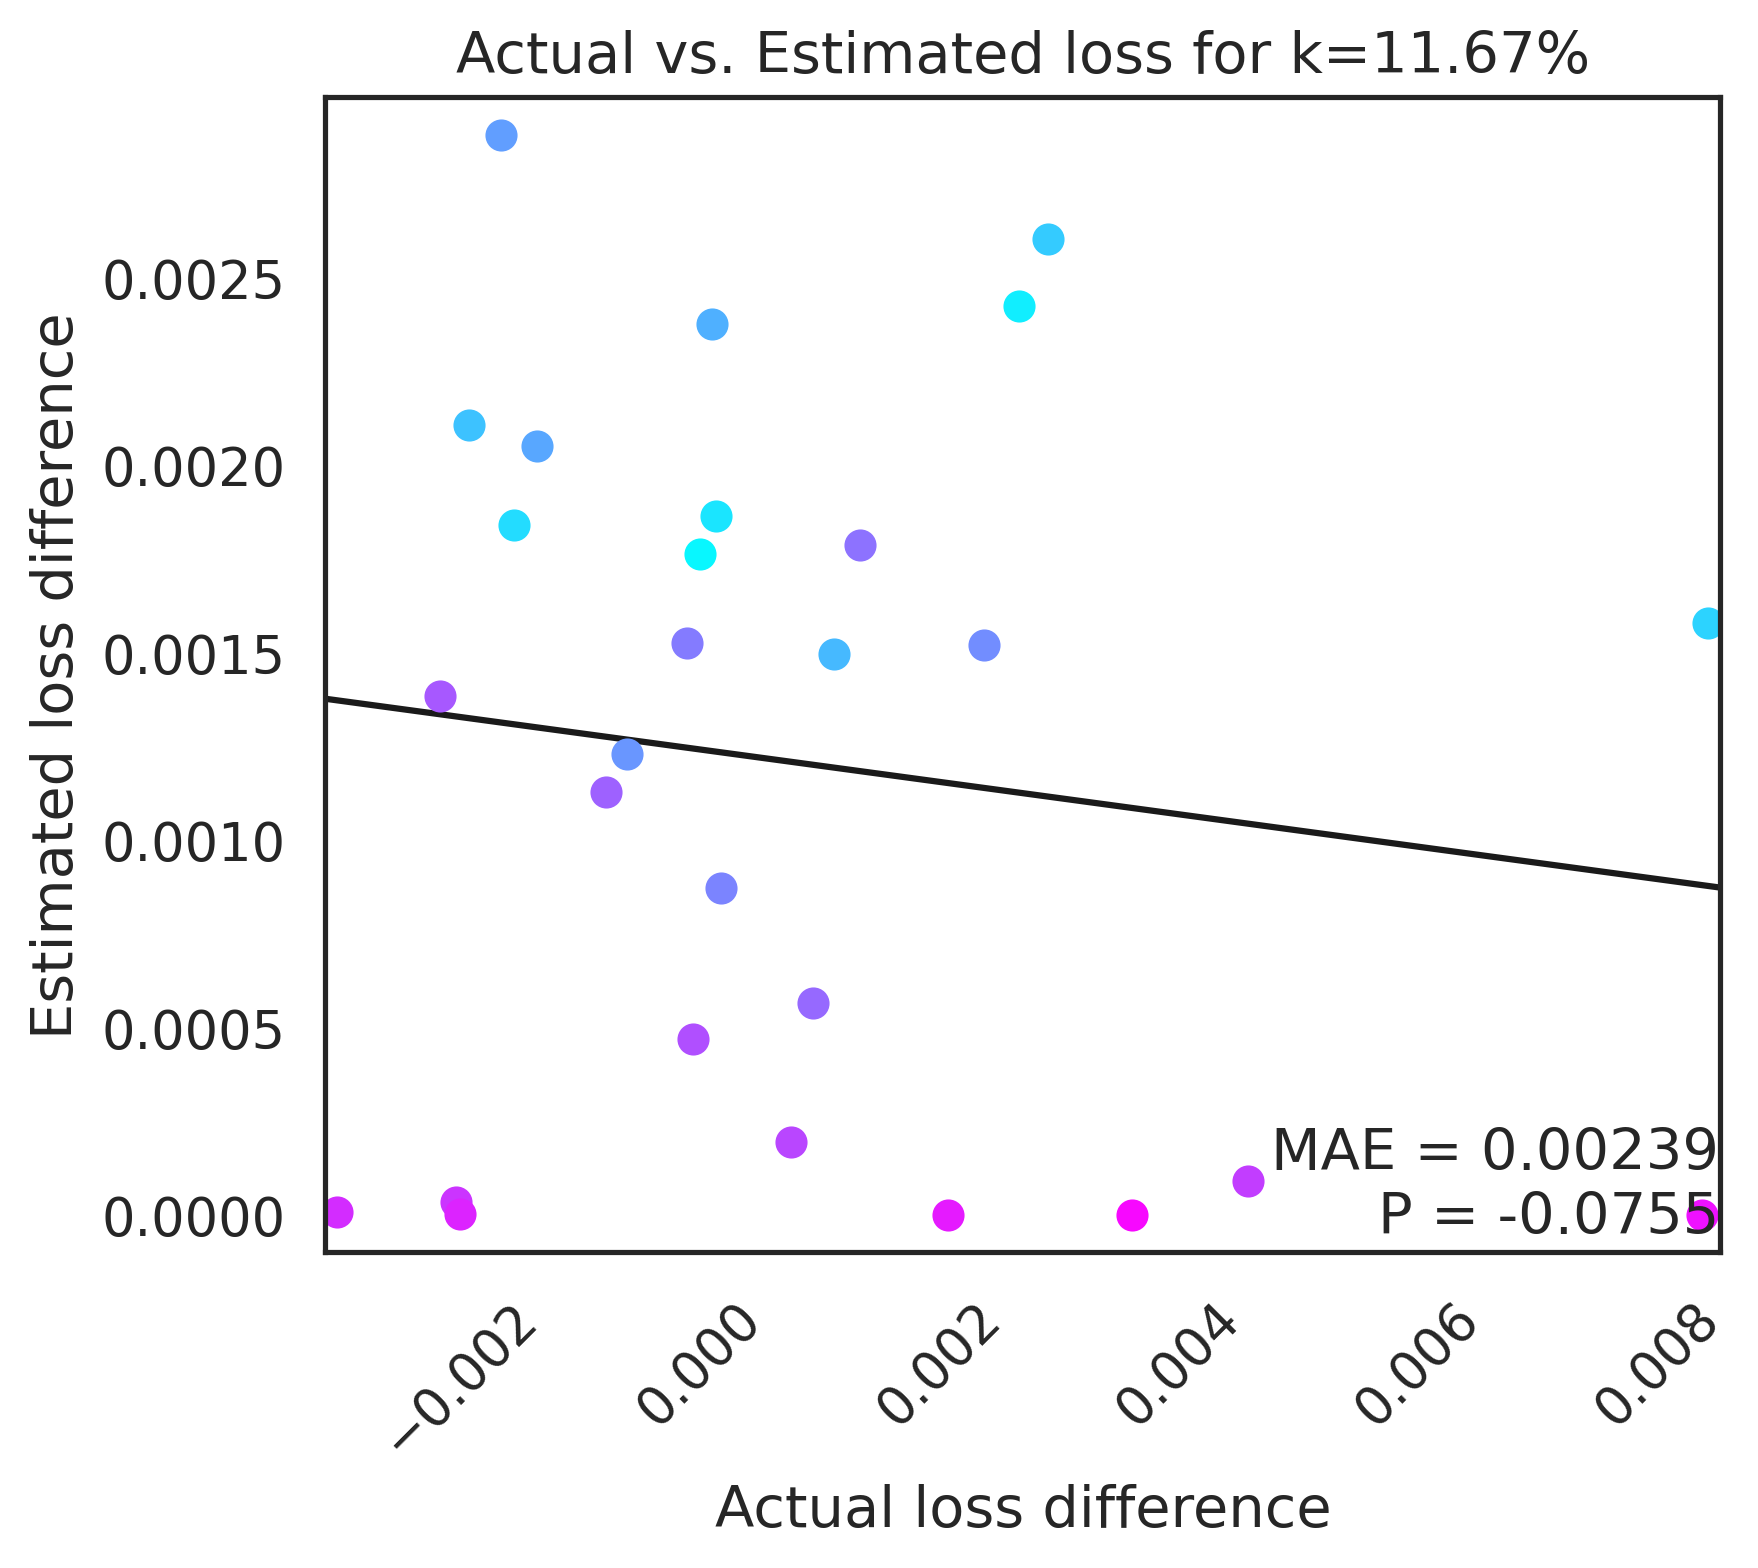

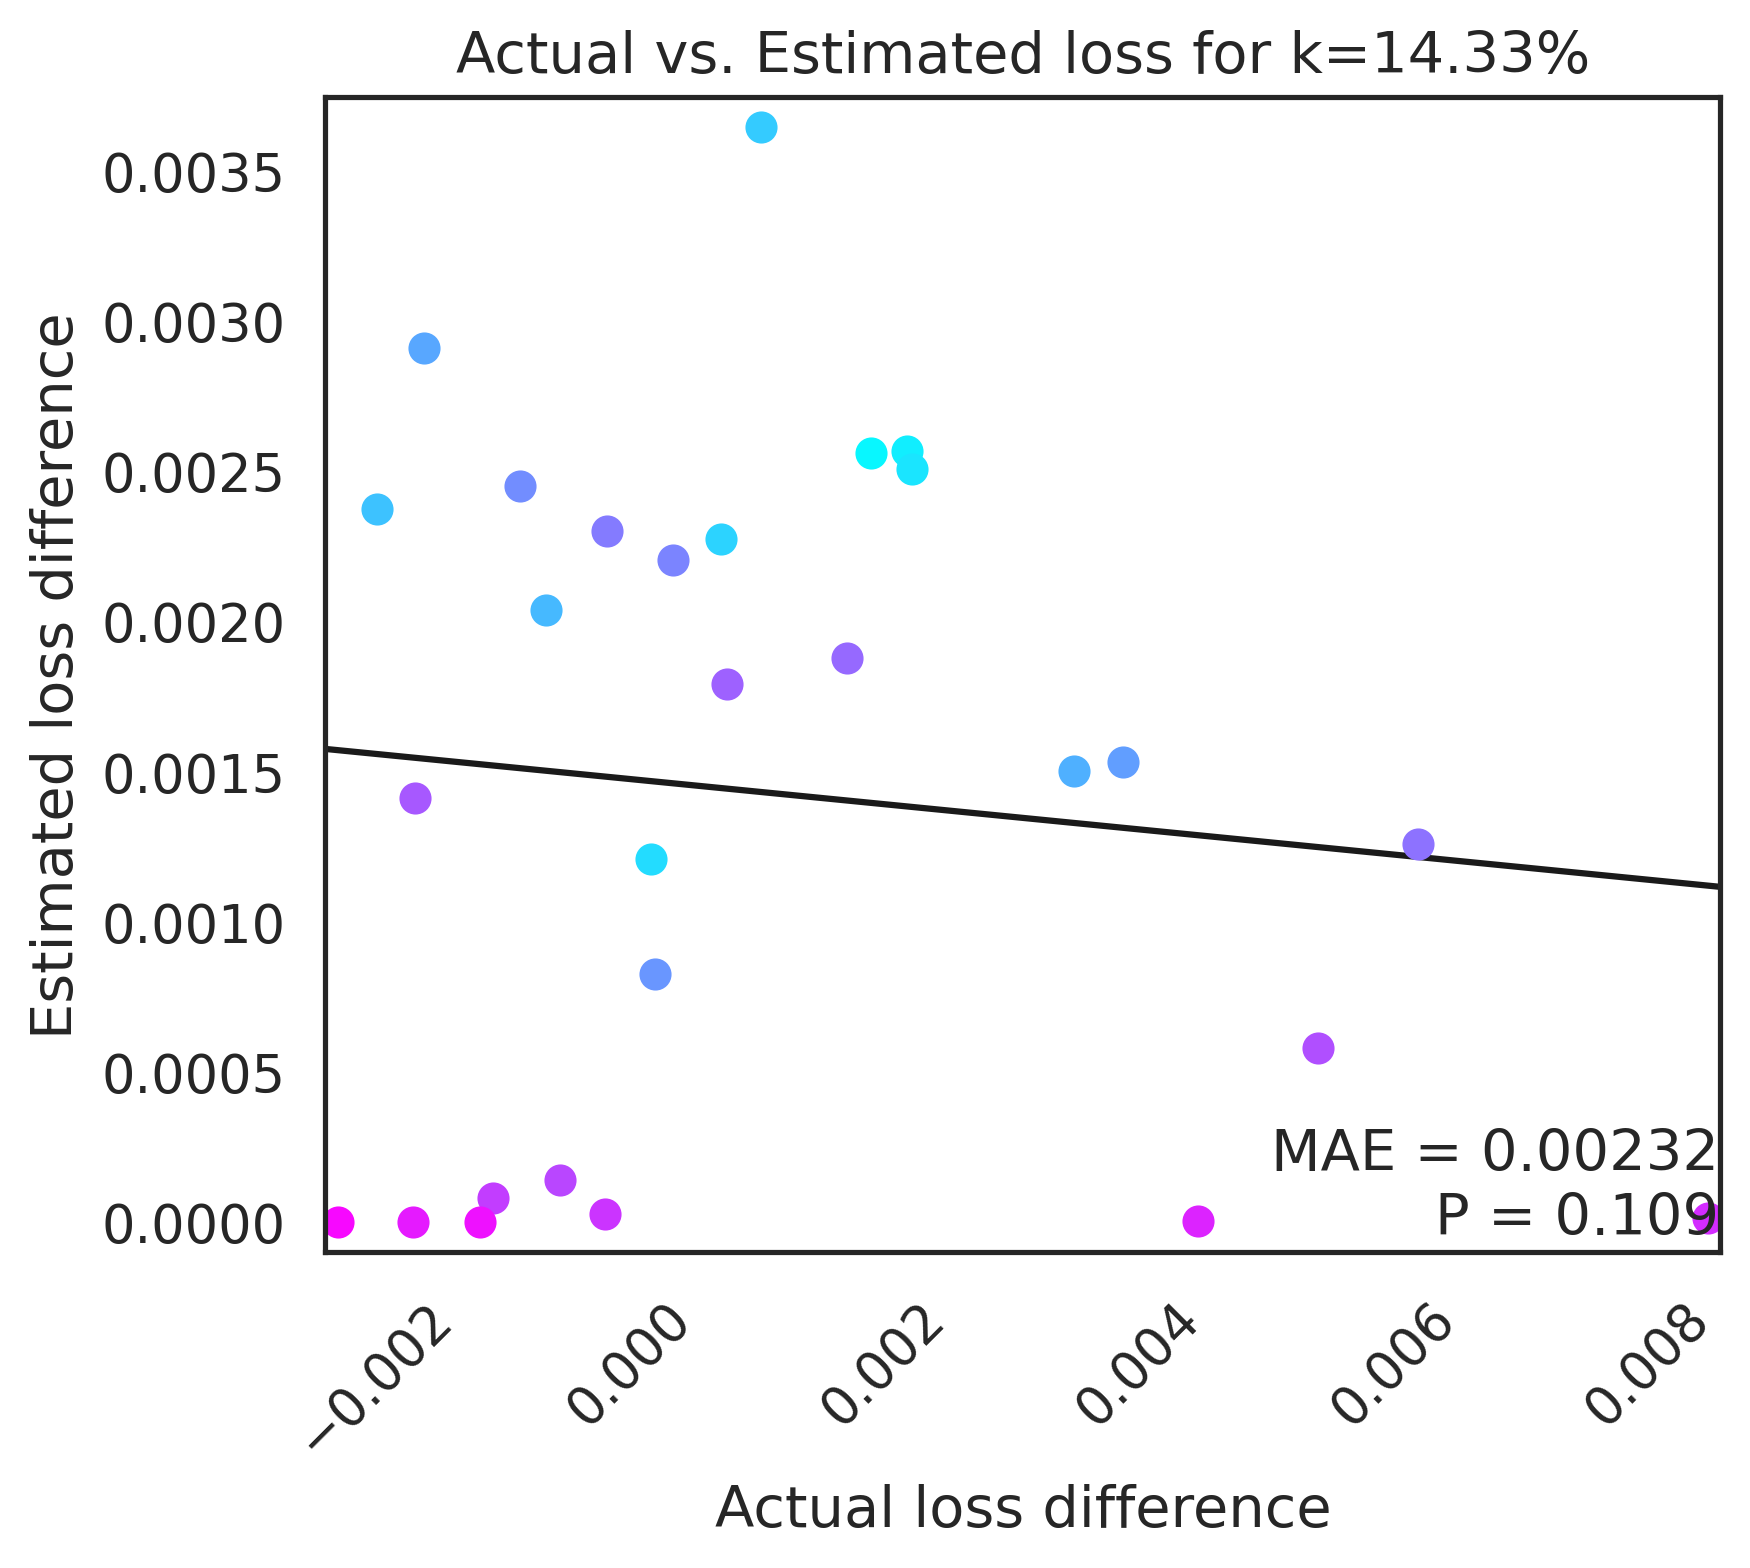

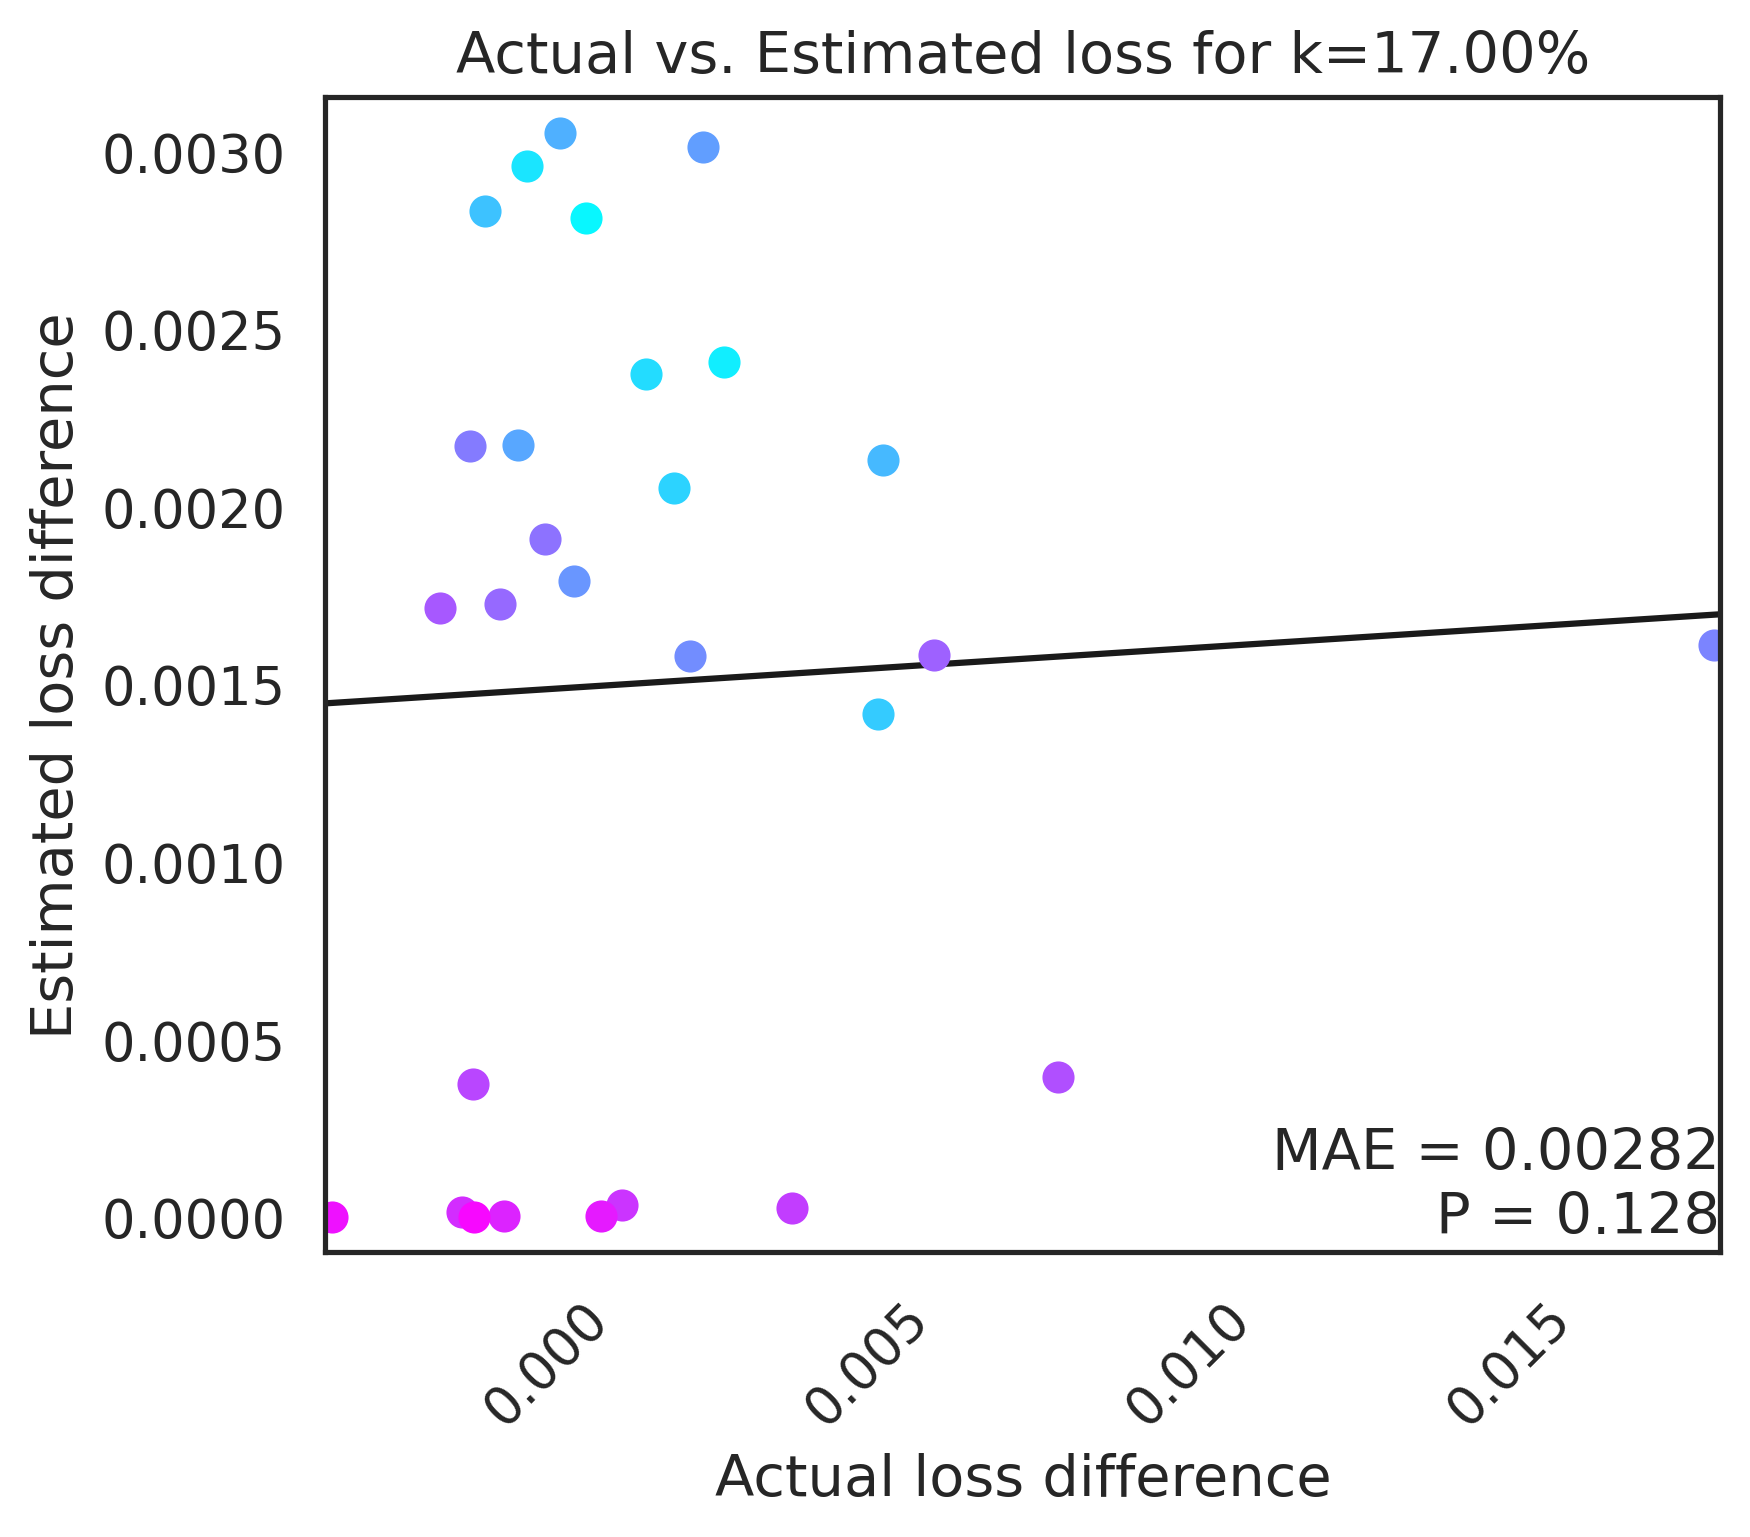

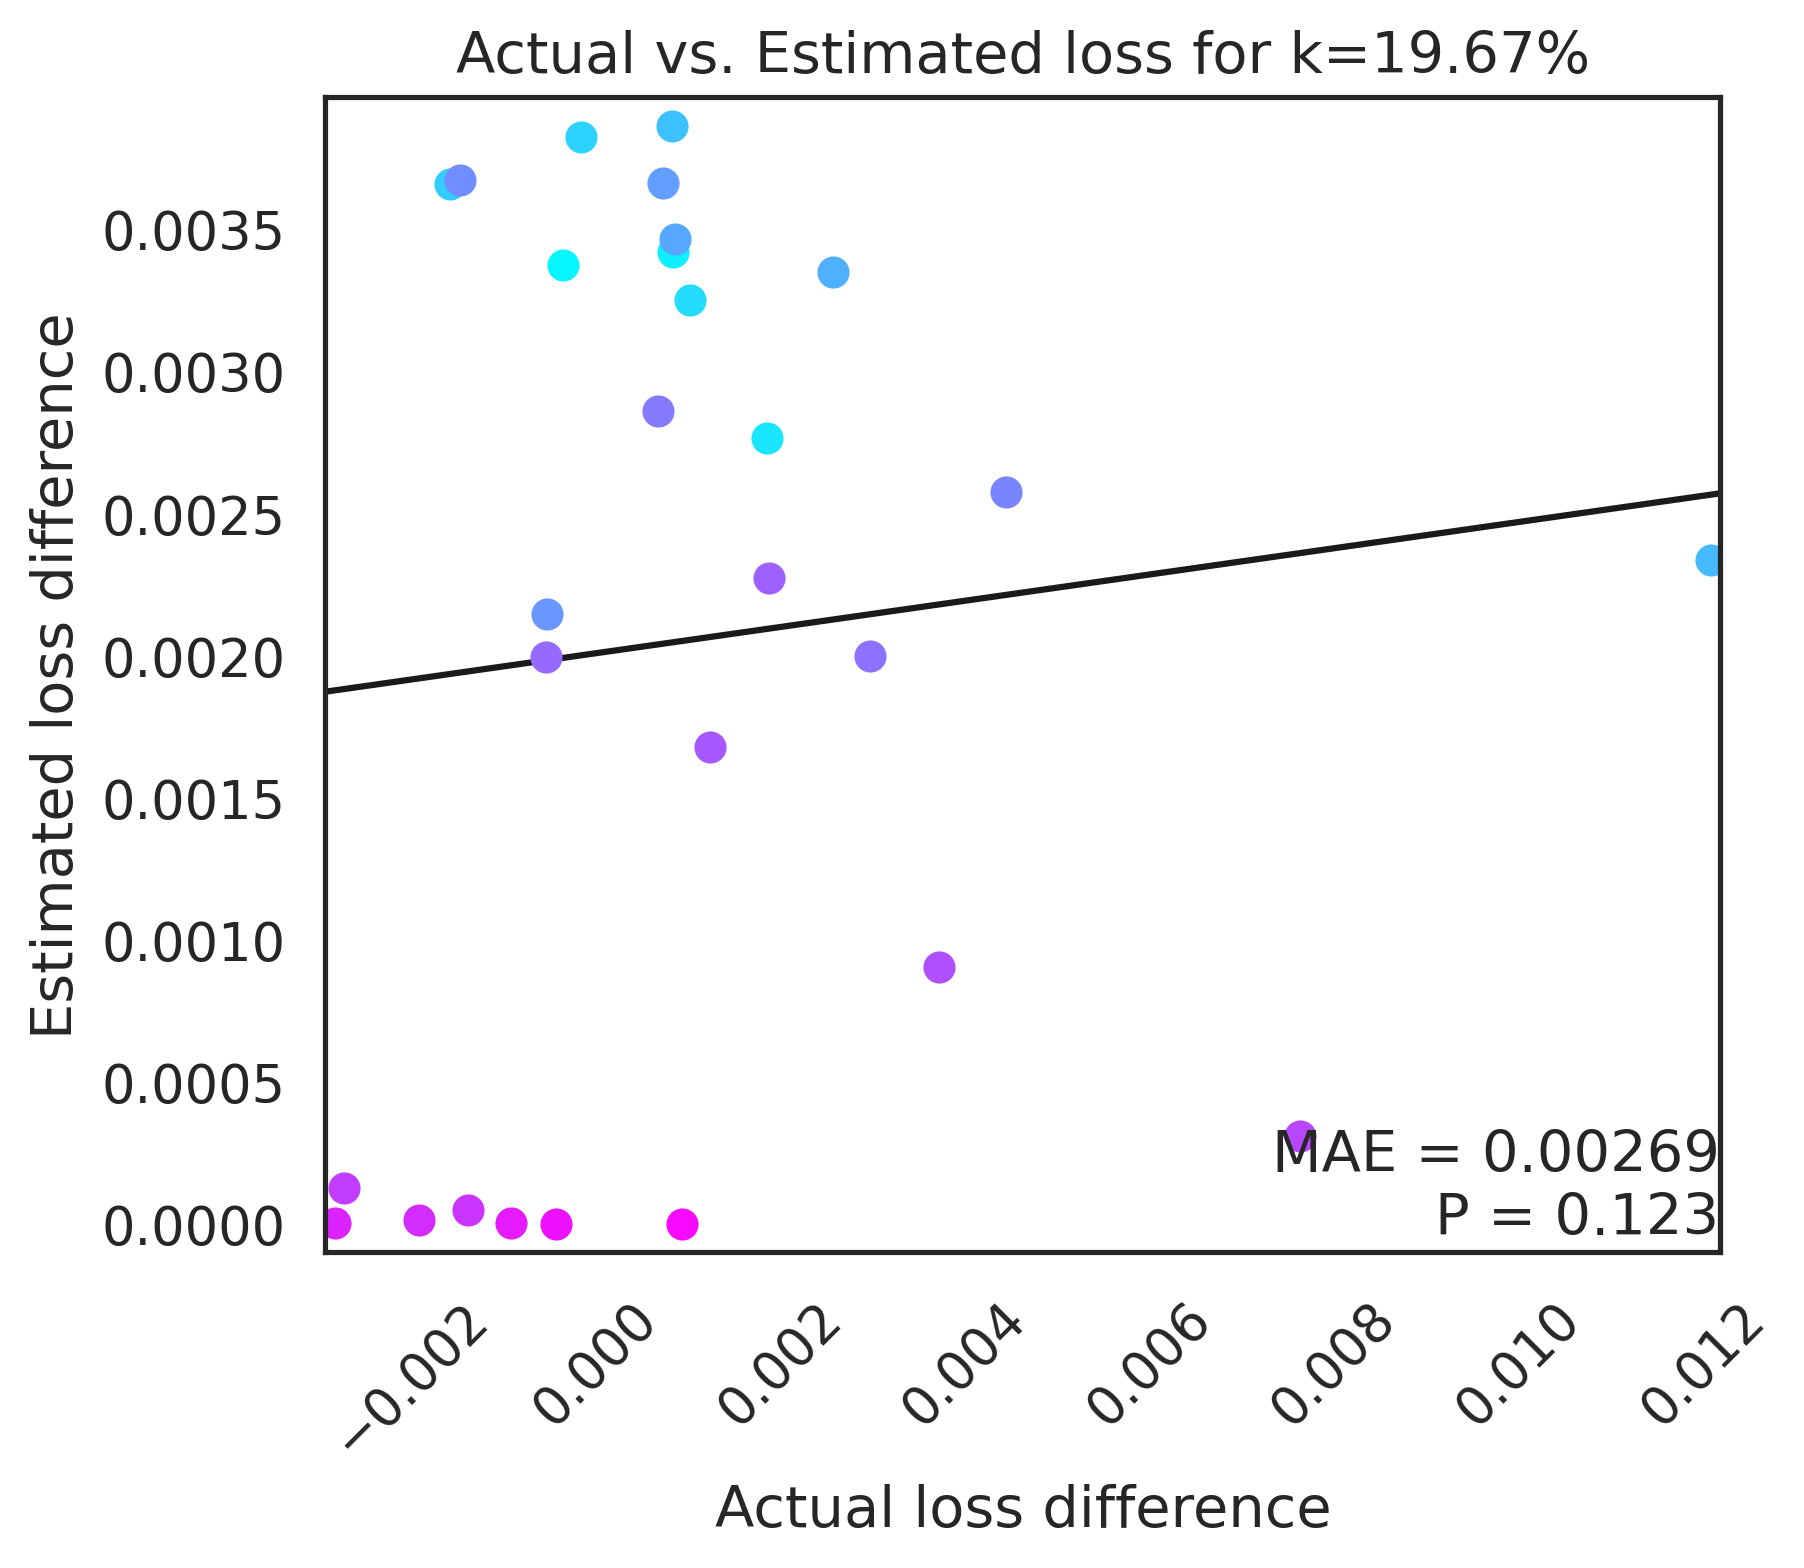

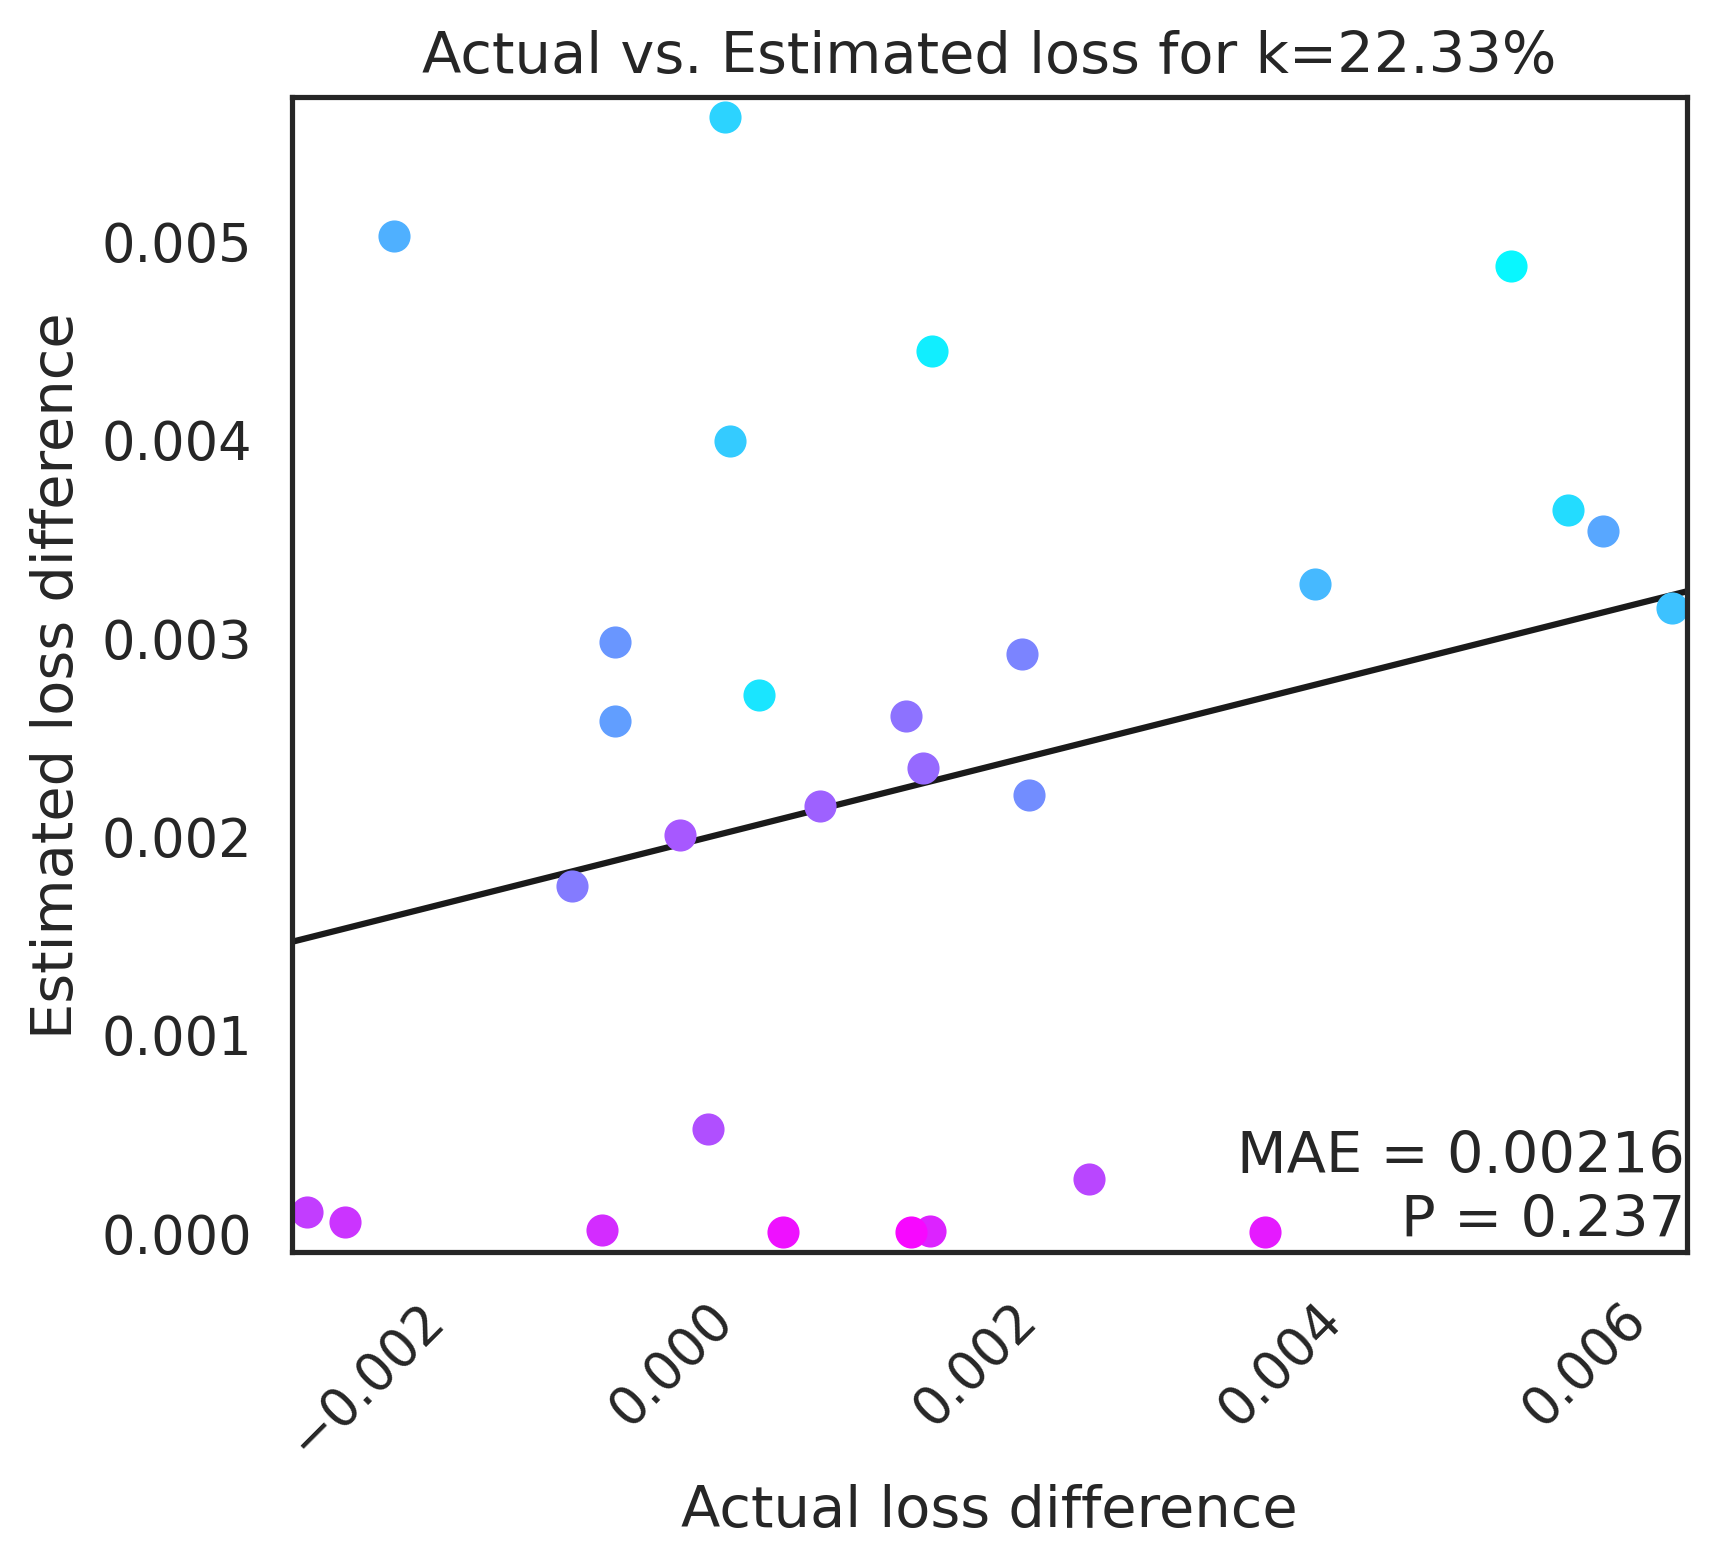

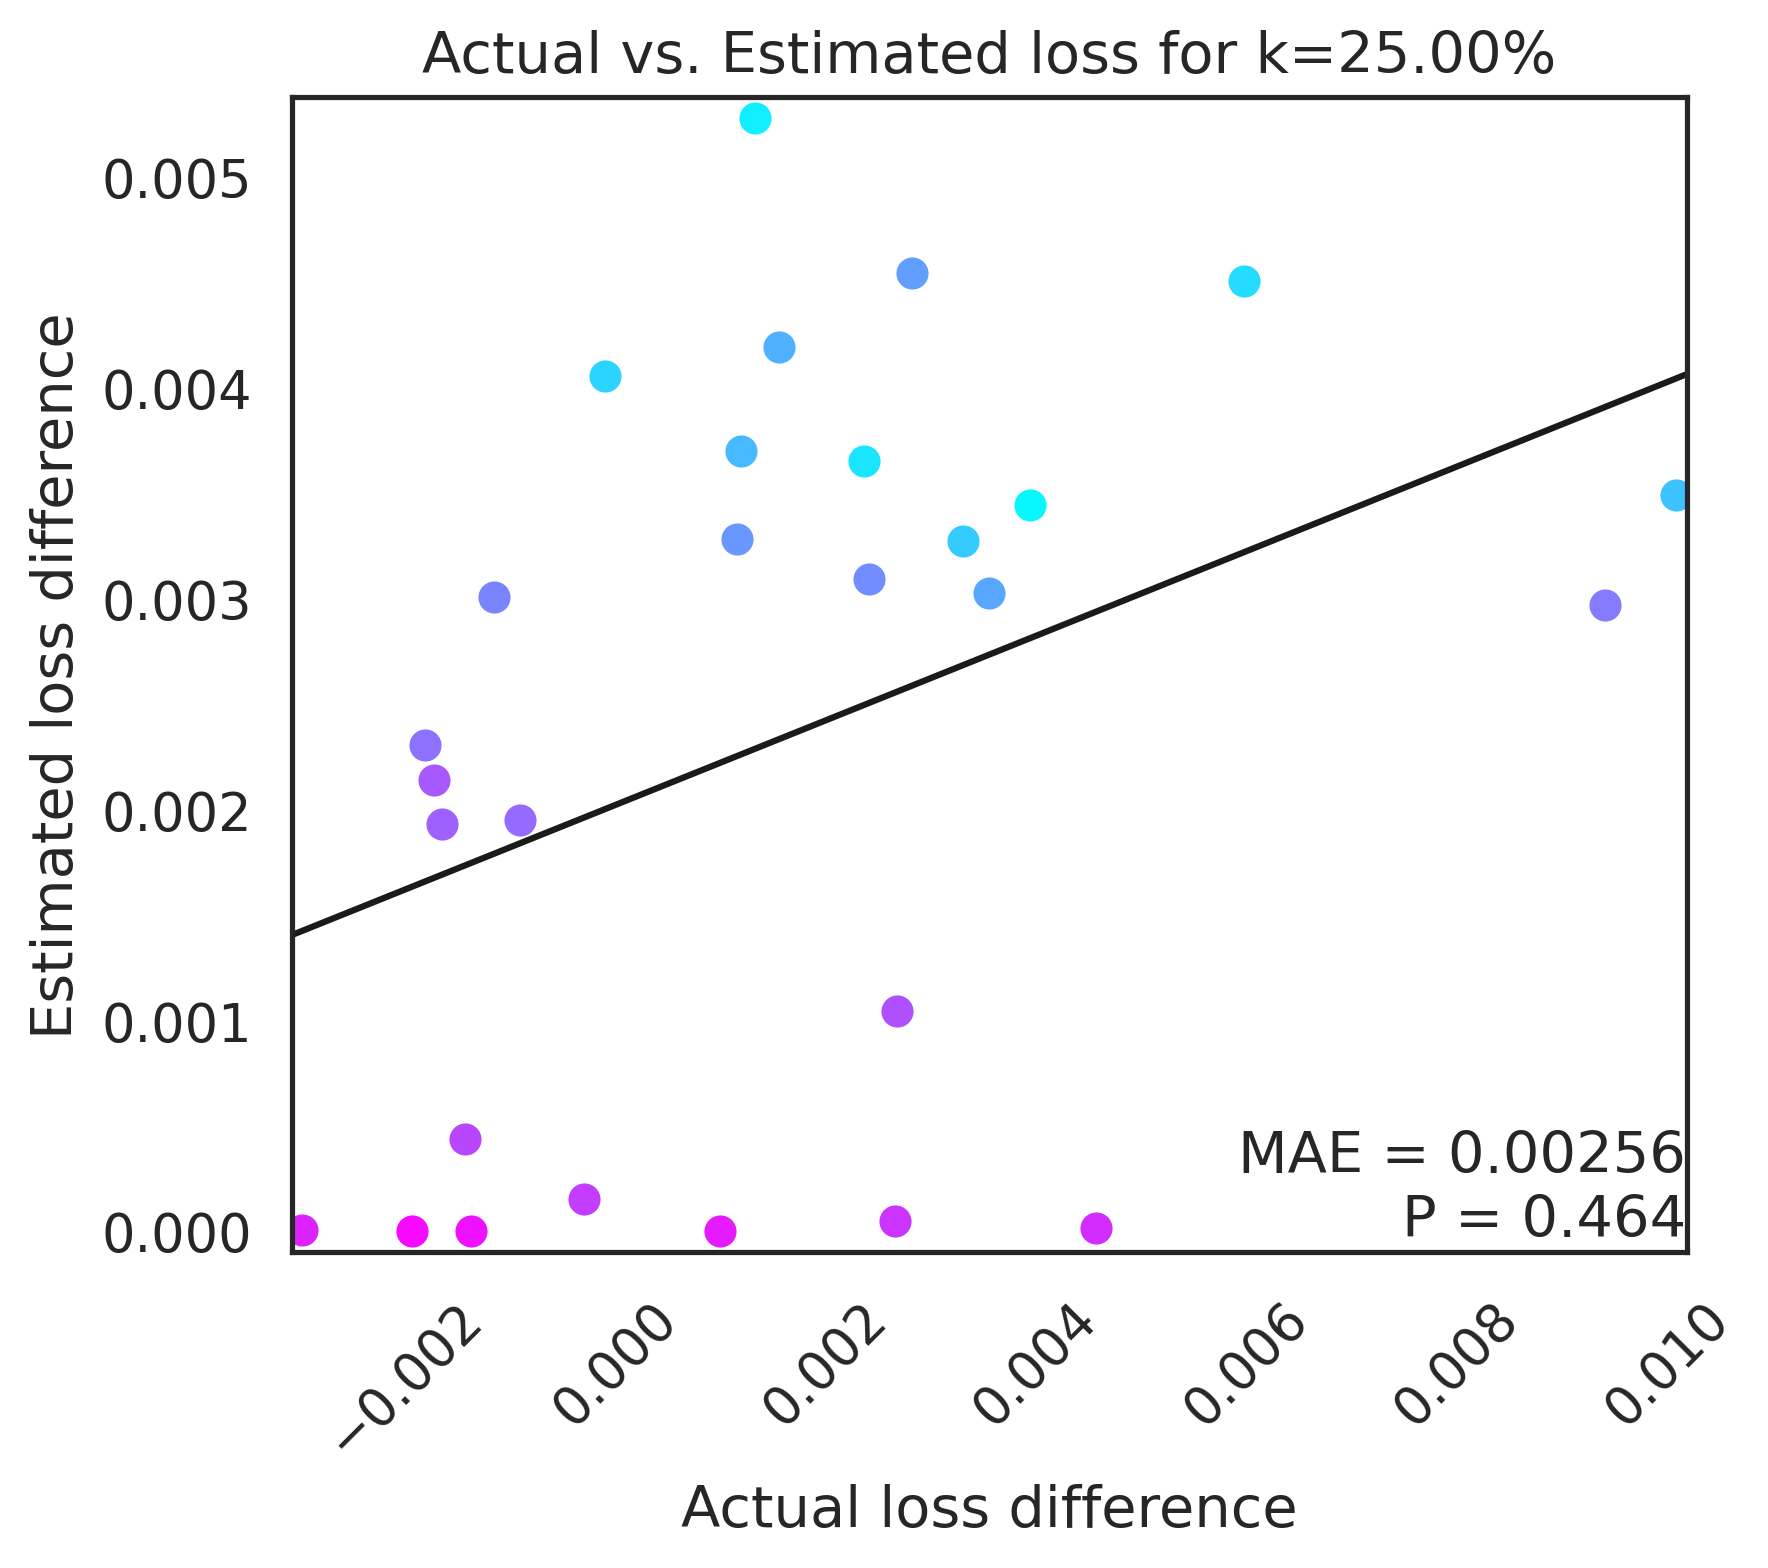

In [21]:
for i in range(len(k_e_orig)):
    visualize_result(k_e_orig[i], k_e_est[i], epsilons, k_[i])